# CH05 CNN 1

# 5.1 CNN

이미지 국소적인 부분 께산 -> 시간, 자원 절약

## 5.1.1 Convolution layer의 필요성

데이터의 공간적 구조를 유지할 수 있기에 필요

## 5.1.2 CNN 구조

### 1. 입력층

height * width * channel(RGB)

### 2. convolution layer

특성 추출 진행 <- kernal/filter 이용 <br>

- 입력 데이터: W1 * H1 * D1 <br>
- 하이퍼파라미터: <br>
 - 필터 수: K
 - 필터 크기: F
 - 스트라이드: S
 - 패딩: P
- 출력 데이터: <br>
 - W2 = (W1-F+2P)/S + 1
 - H2 = (H1-F+2P)/S + 1
 - D2 = K 

### 3. pooling layer

특성맵 차원 다운 -> 연산량 감소

- Max pooling
- average pooling

- 입력 데이터: W1 * H1  * D1
- 하이퍼파라미터: 
- 필터 크기: F
- 스트라이드: S
- 출력 데이터: 
- W2 = (W1 - F)/S + 1
- H2 = (H1 - F)/S + 1
- D2 = D1

### 4. 완전 연결층

3차원 -> 1차원

### 5. 출력층

softmax 사용

## 5.1.3 1D, 2D, 3D 합성곱

### 1D 합성곱

시간 축으로 좌우로만 이동할 수 있는 합성곱 -> 그래프 곡선 완화할 때 사용

### 2D 합성곱

필터가 두 방향으로 움직임 -> 2D행렬

### 3D 합성곱 

필터가 세 방향으로 움직임 -> 3D 행렬

### 3D 입력을 갖는 2D 합성곱

e.g. LeNet-5, VGG

### 1X1 합성곱

e.g. GoogleNet

# 5.2 CNN 맛보기

### 라이브러리 호출

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

### GPU 확인

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### fashion mnist 내려받기

In [7]:
train_dataset = torchvision.datasets.FashionMNIST("/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data", download=True, 
                                                transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data", download=True, train=False,
                                                transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/FashionMNIST/raw



In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

### 클래스 정의

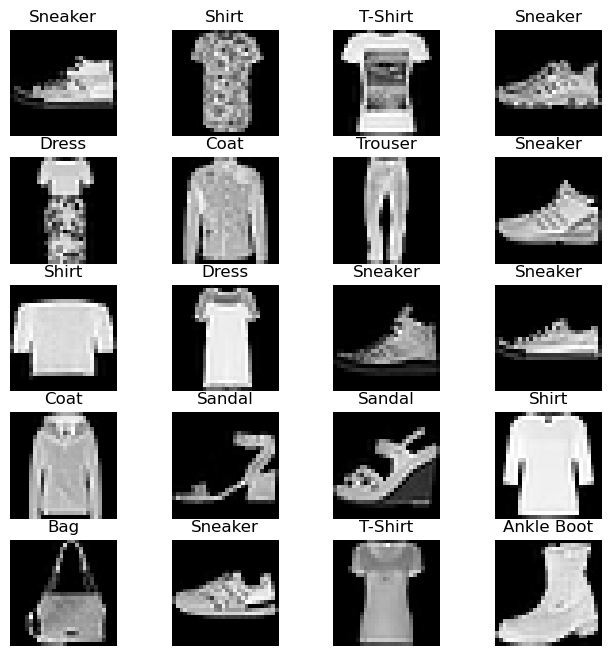

In [10]:
labels_map = {0 : 'T-Shirt', 1: 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4: 'Coat', 5: 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()


### DNN 모델 생성

In [11]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
    
    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


### hyperparameter setting

In [16]:
lr = 0.001
model = FashionDNN()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

DataParallel(
  (module): FashionDNN(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (drop): Dropout(p=0.25, inplace=False)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
)


### 모델 학습

In [17]:
num_epochs = 5
count = 0

loss_list = []
iter_list = []
acc_list = []

pred_list = []
labels_list = []

In [19]:
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_list.append(pred)
                correct += (pred == labels).sum()
                total += len(labels)
            
            acc = correct * 100 / total
            loss_list.append(loss.data)
            iter_list.append(count)
            acc_list.append(acc)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, acc))

Iteration: 500, Loss: 0.6034385561943054, Accuracy: 83.3699951171875%
Iteration: 1000, Loss: 0.372548371553421, Accuracy: 84.27999877929688%
Iteration: 1500, Loss: 0.36582309007644653, Accuracy: 85.8499984741211%
Iteration: 2000, Loss: 0.3974447250366211, Accuracy: 85.68999481201172%
Iteration: 2500, Loss: 0.3069504499435425, Accuracy: 86.18000030517578%
Iteration: 3000, Loss: 0.3200681805610657, Accuracy: 86.63999938964844%


### CNN 모델 생성

In [24]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)

        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [25]:
lr = 0.001
model = FashionCNN()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

DataParallel(
  (module): FashionCNN(
    (layer1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc1): Linear(in_features=2304, out_features=600, bias=True)
    (drop): Dropout2d(p=0.25, inplace=False)
    (fc2): Linear(in_features=600, out_features=120, bias=True)
    (fc3): Linear(in_features=120, out_features=10, bias=True)
  )
)


In [26]:
num_epochs = 5
count = 0

loss_list = []
iter_list = []
acc_list = []

pred_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_list.append(pred)
                correct += (pred == labels).sum()
                total += len(labels)
            
            acc = correct * 100 / total
            loss_list.append(loss.data)
            iter_list.append(count)
            acc_list.append(acc)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, acc))

Iteration: 500, Loss: 0.4382956624031067, Accuracy: 87.80999755859375%
Iteration: 1000, Loss: 0.29703444242477417, Accuracy: 88.50999450683594%
Iteration: 1500, Loss: 0.24612772464752197, Accuracy: 89.6500015258789%
Iteration: 2000, Loss: 0.20644037425518036, Accuracy: 89.73999786376953%
Iteration: 2500, Loss: 0.12539473176002502, Accuracy: 90.31999969482422%
Iteration: 3000, Loss: 0.210710808634758, Accuracy: 90.33999633789062%


# 5.3 Transfer learning

ImageNet같은 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 보정해서 사용하는 것

## 5.3.1 특성 추출 기법

마지막 완전연결층만 학습, 나머지 계층은 학습 X -> 합성곱층 + 데이터 분류기

### 라이브러리 호출

In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data_path = '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/train'

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


### 이미지 데이터 전처리

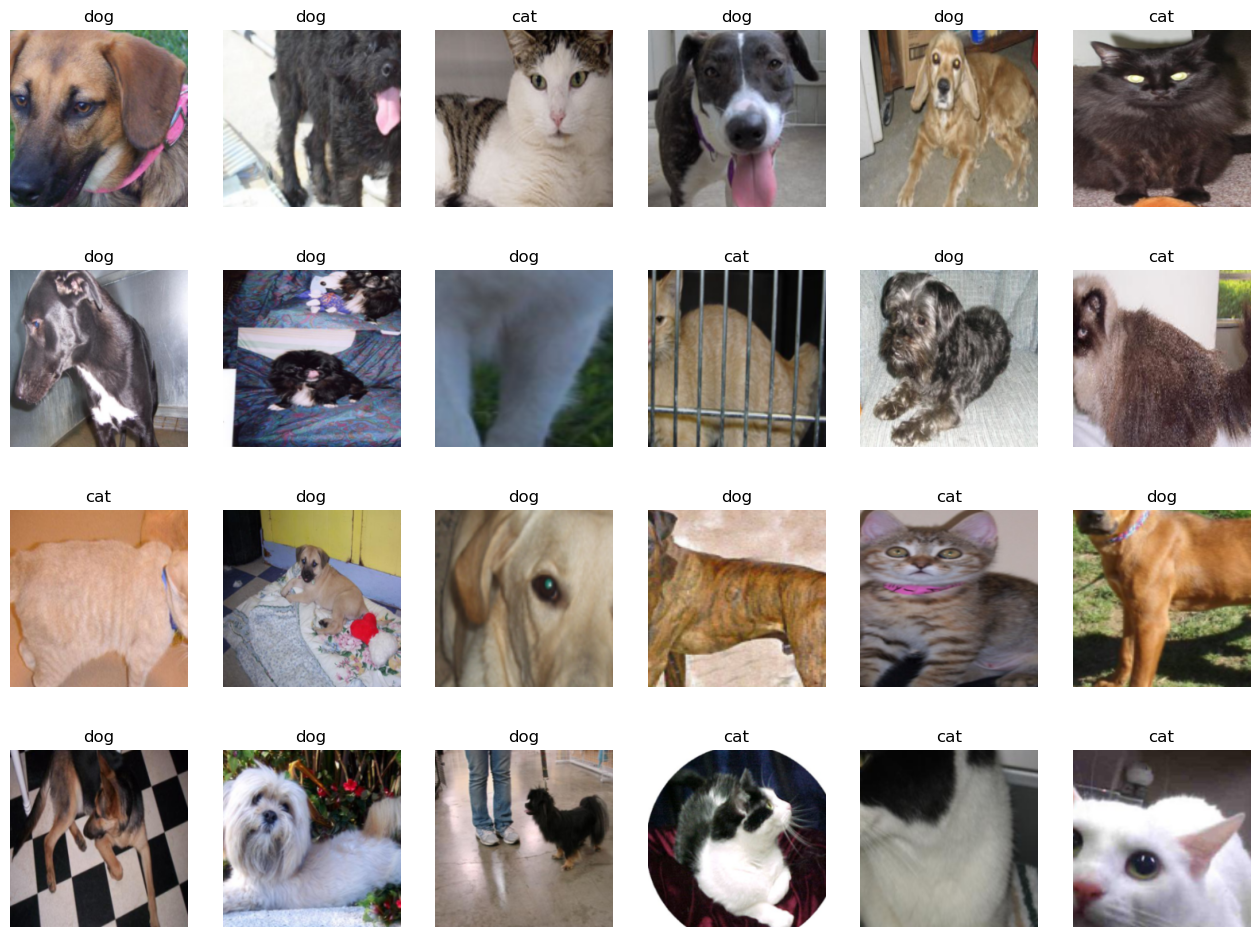

In [3]:
samples, labels = next(iter(train_loader))
classes = {0 : 'cat', 1: 'dog'}

fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

### Pretrained model 내려받기

In [12]:
resnet18 = models.resnet18(pretrained=True)

/home/seungho/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/seungho/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### pretrained model 파라미터 학습 유무 지정

In [13]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [14]:
resnet18.fc = nn.Linear(512, 2)
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0334,  0.0369,  0.0185,  ...,  0.0196,  0.0073,  0.0390],
        [ 0.0311,  0.0095,  0.0417,  ..., -0.0065, -0.0291,  0.0370]])
fc.bias tensor([-0.0137, -0.0056])


### 모델 객체 생성 및 손실 함수 정의

In [15]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 모델 학습 함수 생성

In [33]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=50, is_train=True):
    since = time.time()
    acc_hist = []
    loss_hist = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0


        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_hist.append(epoch_acc.item())
        loss_hist.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog', '{0:0=2d}.pth'.format(epoch)))
        print()
    
    time_elapsed = time.time() - since
    print('Training  complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_hist, loss_hist

In [34]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)
optimizer = optim.Adam(params_to_update)


	 fc.weight
	 fc.bias


### 모델 학습

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/49
----------
Loss: 0.1804 Acc: 0.9143

Epoch 1/49
----------
Loss: 0.2035 Acc: 0.9169

Epoch 2/49
----------
Loss: 0.1638 Acc: 0.9377

Epoch 3/49
----------
Loss: 0.2003 Acc: 0.9091

Epoch 4/49
----------
Loss: 0.2295 Acc: 0.8987

Epoch 5/49
----------
Loss: 0.1700 Acc: 0.9299

Epoch 6/49
----------
Loss: 0.1711 Acc: 0.9273

Epoch 7/49
----------
Loss: 0.2058 Acc: 0.8987

Epoch 8/49
----------
Loss: 0.2180 Acc: 0.9013

Epoch 9/49
----------
Loss: 0.2224 Acc: 0.8961

Epoch 10/49
----------
Loss: 0.1649 Acc: 0.9143

Epoch 11/49
----------
Loss: 0.1711 Acc: 0.9325

Epoch 12/49
----------
Loss: 0.1627 Acc: 0.9273

Epoch 13/49
----------
Loss: 0.1811 Acc: 0.9065

Epoch 14/49
----------
Loss: 0.1936 Acc: 0.9091

Epoch 15/49
----------
Loss: 0.1868 Acc: 0.9221

Epoch 16/49
----------
Loss: 0.1686 Acc: 0.9117

Epoch 17/49
----------
Loss: 0.1778 Acc: 0.9169

Epoch 18/49
----------
Loss: 0.1908 Acc: 0.9065

Epoch 19/49
----------
Loss: 0.1932 Acc: 0.9299

Epoch 20/49
----------
Loss: 0

### 테스트 데이터

In [40]:
test_path = '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/test'

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


### 평가 함수 생성

In [55]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_hist = []
    best_acc = 0.0

    saved_models = glob.glob('/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)
    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0

            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        acc_hist.append(epoch_acc.item())
        print()
        
    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_hist

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/00.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/01.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/02.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/03.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/04.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/05.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/06.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/07.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/catanddog/08.pth', '/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/08028

### Train, Test Accuracy

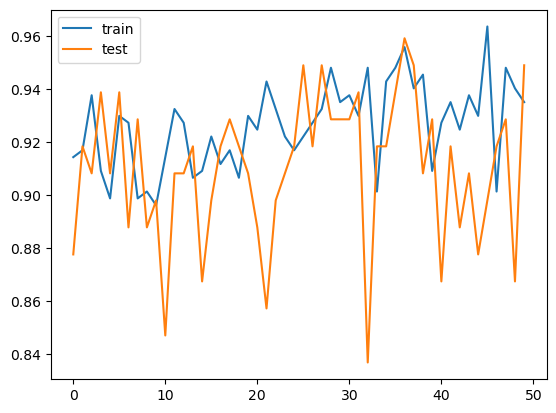

In [57]:
plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='test')
plt.legend()
plt.show()

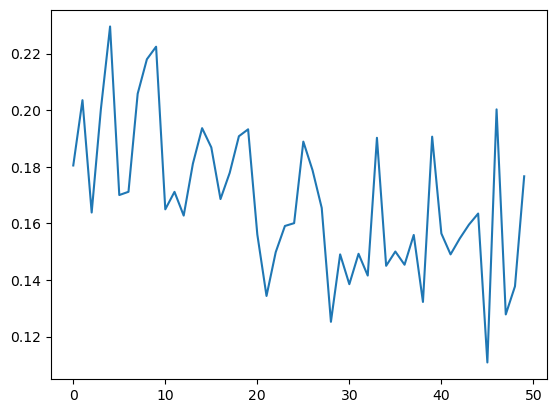

In [58]:
plt.plot(train_loss_hist)
plt.show()

### 에측 이미지 출력

In [64]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip(0, 1)
    return image


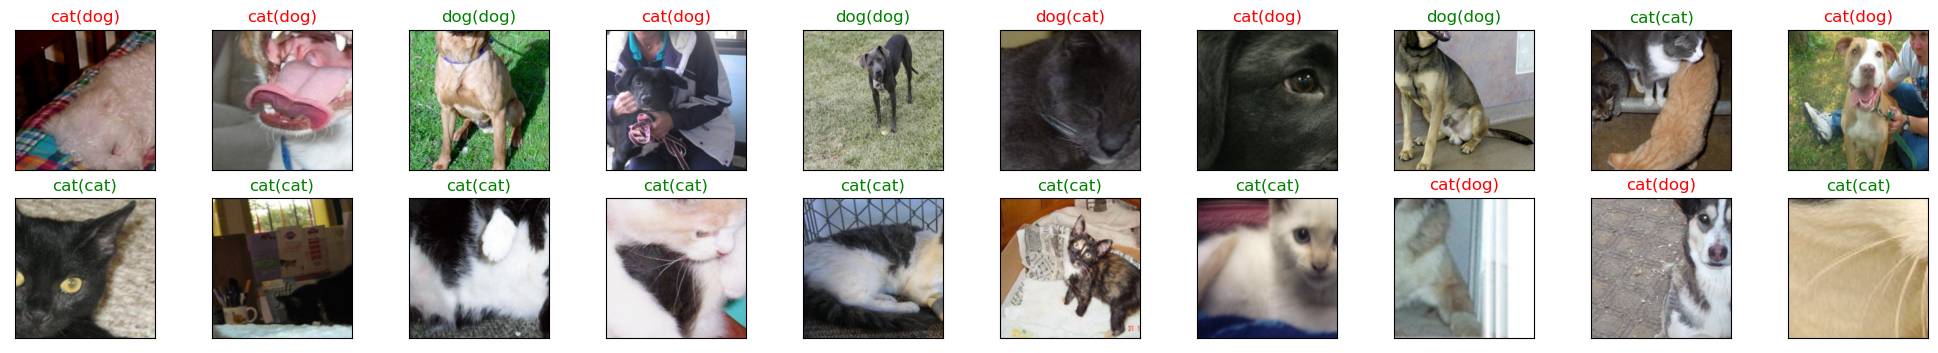

<Figure size 640x480 with 0 Axes>

In [67]:
classes = {0: 'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## 5.3.2 fine tuning

- 데이터셋 big, pretrained model과 similarity low -> 모델 전체 재학습
- 데이터셋 big, pretrained model과 similarity high -> 합성곱층의 뒷부분과 데이터 분류기만 새로 학습
- 데이터셋 small, pretrained model과 similarity low -> 합성곱층 일부와 데이터 분류기 학습(효과 없을수도)
- 데이터셋 small, pretrained model과 similarity high -> 데이터 분류기만 학습

# 5.4 설명가능한 CNN

CNN 처리과정에 대한 시각화

## 5.4.1 특성 맵 시각화

### 라이브러리

In [68]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Explainable network 생성

In [93]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [105]:
model = XAI()
model.to(device)
model.eval()


XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

### 특성맵 확인 위한 클래스 정의

In [106]:
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output.detach().cpu().numpy()
    
    def remove(self):
        self.hook.remove()

### 이미지 호출

torch.Size([1, 3, 100, 100])


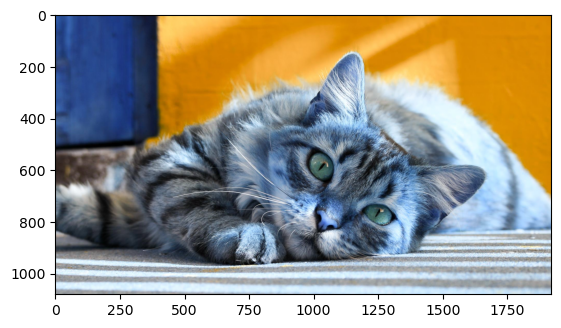

In [107]:
img = cv2.imread("/media/seungho/53b8a3a8-75cd-4363-9fed-296ae95f1c27/code_study/080289/chap05/data/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100,100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [112]:
result = LayerActivations(model.features, 0)
img = img.to(device)
model(img)
activations = result.features

/tmp/ipykernel_60157/1460188688.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


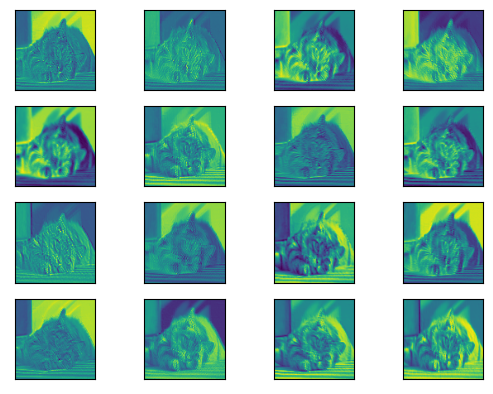

<Figure size 1200x800 with 0 Axes>

In [113]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for col in range(4):
        axis = axes[row][col]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+col])
plt.show()

In [114]:
result = LayerActivations(model.features, 20)
img = img.to(device)
model(img)
activations = result.features

/tmp/ipykernel_60157/1460188688.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


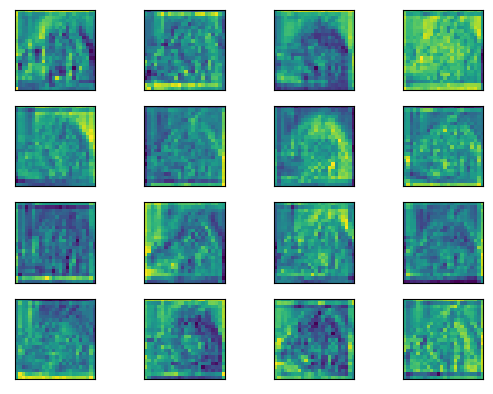

<Figure size 1200x800 with 0 Axes>

In [115]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for col in range(4):
        axis = axes[row][col]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+col])
plt.show()

In [116]:
result = LayerActivations(model.features, 40)
img = img.to(device)
model(img)
activations = result.features

/tmp/ipykernel_60157/1460188688.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


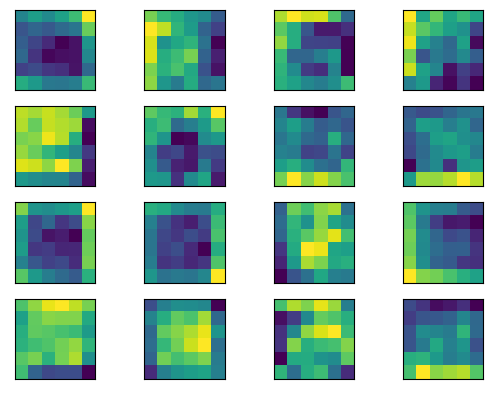

<Figure size 1200x800 with 0 Axes>

In [117]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for col in range(4):
        axis = axes[row][col]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+col])
plt.show()

# 5.5  그래프 합성곱 네트워크(GCN)

그래프 데이터를 위한 신경망

## 5.5.1 그래프란

directed, undirected edge로 연결된 노드의 집합

## 5.5.2 그래프 신경망(GNN)

1. 인접행렬
2. 특성행렬

## 5.5.3 GCN

- SNS 관계 네트워크
- 학술 연구 인용 네트워크
- 3D Mesh